In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Utility Functions

In [3]:
"""
Loads an image from path.
"""
def get_im(path):
    im = cv2.imread(path)
    return im

"""
Displays a BGR image.
"""
def display_bgr(im):
    plt.imshow(im[:,:,[2,1,0]])
    plt.show()

"""
Displays images relating to prepped upsampling (original, downsampled, prepped, upsampled).
Assumes a BGR image format.
"""
def display_prepped_upsampling_results(original_im, downsampled_im, prepped_im, upsampled_im):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle("Results for Prepped Upsampling", fontsize=16)

    # Display the images
    axs[0, 0].imshow(original_im[:,:,[2,1,0]])
    axs[0, 0].set_title("Original")
    
    axs[0, 1].imshow(downsampled_im[:,:,[2,1,0]])
    axs[0, 1].set_title("Downsampled")
    
    axs[1, 0].imshow(prepped_im[:,:,[2,1,0]])
    axs[1, 0].set_title("Prepped")
    
    axs[1, 1].imshow(upsampled_im[:,:,[2,1,0]])
    axs[1, 1].set_title("Upsampled")
    
    plt.show()
    
"""
Displays images relating to no-prep upsampling (original, downsampled, upsampled).
Assumes a BGR image format.
"""
def display_upsampling_results(original_im, upsampled_im):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Results for Upsampling", fontsize=16)

    # Display the images
    axs[0].imshow(original_im[:,:,[2,1,0]])
    axs[0].set_title("Original")
    
    axs[1].imshow(upsampled_im[:,:,[2,1,0]])
    axs[1].set_title("Upsampled")
    
    plt.show()
    
"""
Given an image, removes on row/column from either or both dimensions to ensure image shape is even.
"""
def make_even_shape(im):
    if im.shape[0] % 2 != 0 and im.shape[1] != 0:
        return im[:im.shape[0]-1, :im.shape[1]-1]
    
    elif im.shape[0] % 2 != 0:
        return im[:im.shape[0]-1, :]
    
    elif im.shape[1] % 2 != 0:
        return im[:, im.shape[1]-1]
    
    else:
        return im

# Metrics

In [4]:
"""
Calculates the mean squared difference per pixel between two images of the same shape.
Lower MSE indicates more similar images.
With perfect similarity, MSE=0.
"""
def mse(im1, im2):
    error = np.sum((im1.astype(float) - im2.astype(float)) ** 2)
    error /= im1.shape[0] * im1.shape[1]
        
    return error

"""
Calculates the root mean squared difference per pixel between two images of the same shape.
Lower RMSE indicates more similar images.
With perfect similarity, RMSE=0.
"""
def rmse(im1, im2):
    error = np.sqrt(mse(im1, im2))
    
    return error


"""
Calculate the mean absolute difference per pixel between two images of the same shape.
Lower MAE indicates more similar images.
With perfect similarity, MAE=0.
"""
def mae(im1, im2):
    error = np.sum(np.abs(im1.astype(float) - im2.astype(float)))
    error /= im1.shape[0] * im1.shape[1]  
    
    return error

"""
Calculate the peak signal to noise ratio between two images of the same shape.
Higher PSNR indicates higher-quality reconstruction (generally in the range of 30-50Db).
With perfect similarity, PSNR=infinity
"""
def psnr(im1, im2):
    # https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
    error = (20 * np.log10(255)) - (10 * np.log10(mse(im1, im2)))
    
    return error
    

"""
Calculate the structural similarity index measure between two images of the same shape.
Higher SSIM indicates more similarity between images (luminence, constrast, structural information), on a 
-1 to 1 scale.
With perfect similarity, SSIM=1.
"""
def ssim(im1, im2):
    # https://en.wikipedia.org/wiki/Structural_similarity
    mean1 = np.mean(im1)
    mean2 = np.mean(im2)
    
    var1 = np.mean((im1 - mean1) ** 2)
    var2 = np.mean((im2 - mean2) ** 2)
    
    cov = np.mean((im1 - mean1) * (im2 - mean2))
    
    L = 255
    k1 = 0.01
    k2 = 0.03
    
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2
    c3 = c2 / 2
    
    l = ((2 * mean1 * mean2) + c1) / ((mean1 ** 2) + (mean2 ** 2) + c1)
    c = ((2 * var1 * var2) + c2) / ((var1 ** 2) + (var2 ** 2) + c2)
    s = (cov + c3) / ((np.sqrt(var1) * np.sqrt(var2)) + c3)

    error = l * c * s
    
    return error

In [5]:
"""
Test that metric functions behave as expected for perfect similarity:
MSE, MAE, RMSE = 0.
PSNR = infinity.
SSIM = 1.
"""
im = get_im("no_black_logo.jpg")

print("MSE", mse(im, im))
print("RMSE", rmse(im, im))
print("MAE", mae(im, im))
print("PSNR", psnr(im, im))
print("SSIM", ssim(im, im))

MSE 0.0
RMSE 0.0
MAE 0.0
PSNR inf
SSIM 0.9999999999999998


C:\Users\Ematt\AppData\Local\Temp\ipykernel_5272\2976842692.py:41: RuntimeWarning: divide by zero encountered in log10
  error = (20 * np.log10(255)) - (10 * np.log10(mse(im1, im2)))


# Downsampling

Here we implement downsampling approaches to be used in our pipeline. We will use these functions to downsample our test images, upsample those downsamples, then compare with the original.

In [6]:
"""
Downsamples an image by factor of 2 by throwing out every odd indexed pixel.
Assumes even image shape

"""
def downsample(im):
    shape = im.shape
    new_shape = (shape[0] // 2, shape[1] // 2, shape[2])

    new_im = np.zeros(new_shape, dtype=float)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if j % 2 == 0 and i % 2 == 0:
                new_im[i//2, j//2] = im[i, j]
                    
    return new_im

def cv2_downsample(im):
    # https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
    scale_percent = 50 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
  
    # resize image
    resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    
    return resized

# "Prepped" Upsampling

Here we define an approach to upsampling that "prepares" the upsampled image prior to performing any interpolation.
"Preparation" here refers to generating an image with shape equal to the desired upsample, filled with original pixel values (from the downsampled image) where they would appear in the upsampled image, and empty (black) pixels everywhere else. This approach adds significant computation/runtime to the pipeline, but may provide more control than less supervised implementations (implemented / to-be implemented further below).

In [7]:
"""
Prepares to upsample and image by factor of 2 by creating an image where every even indexed pixel originates from
the provided image and every odd indexed pixel is empty.
"""
def prep_upsample(im):
    new_shape = (im.shape[0] * 2, im.shape[1] * 2, im.shape[2])
    new_im = np.zeros(new_shape, dtype=float)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            new_im[i*2, j*2] = im[i, j]
                            
    return new_im

In [8]:
"""
Given a prepped image, fills in the "empty" pixels (odd indices) by averaging all even indexed pixels up to k steps away.
This implementation only works for images prepped by prep_upsample
"""
def KNN_upsample_prepped(im, k=1):
    new_im = np.zeros_like(im, dtype=float)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if i % 2 == 1 or j % 2 == 1:
                # Must fill this value by performing a KNN average
                neighbor_pixel_values = []
                for m in range(max(0, i-k), min(i+k+1, im.shape[0]-1)):
                    for n in range(max(0, j-k), min(j+k+1, im.shape[1]-1)):
                        if m % 2 == 0 and n % 2 == 0:
                            neighbor_pixel_values.append(im[m, n])
                            
                to_average = np.array(neighbor_pixel_values)
                avg_value = np.mean(to_average, axis=0)
                new_im[i, j] = avg_value
            else:
                new_im[i, j] = im[i, j]
                
    
    return new_im

# "No-Prep" Upsampling

Here we implement approaches to upsampling that need not generate any intermediary images. These approaches will only calculate the bare minimum pre-upsampling information required to perform the task.

In [9]:
"""
Given an image, upsamples both dimensions by a factor of 2. This is equivilant to the "KNN_upsample_prepped" function
without the necessity for creating an intermediary prepped image.
"""
def KNN_upsample_no_prep(im, k=1):
    factor = 2
    new_im = np.zeros((im.shape[0] * factor, im.shape[1] * factor, im.shape[2]), dtype=float)
    for i in range(new_im.shape[0]):
        for j in range(new_im.shape[1]):
            if i % factor == 0 and j % factor == 0:
                # This index exists in the original image, so we can just copy its value
                new_im[i, j] = im[i // factor, j // factor]
            
            else:
                # This index doesn't exist in the original image, so we must interpolate its value
                neighbor_pixel_values = []
                # Find all pixels within the original image that are within k steps away from the index we wish to interpolate
                for m in range(max(0, i-k), min(i+k+1, new_im.shape[0]-1)):
                    for n in range(max(0, j-k), min(j+k+1, new_im.shape[1]-1)):
                        if m % factor == 0 and n % factor == 0:
                            neighbor_pixel_values.append(im[m // factor, n // factor])
                            
                to_average = np.array(neighbor_pixel_values)
                avg_value = np.mean(to_average, axis=0)
                new_im[i, j] = avg_value     
    
    return new_im

In [10]:
"""
Given an image, upsamples both dimensions by some factor.
"""
def KNN_upsample_variable_factor(im, k=1, factor=2):
    new_im = np.zeros((im.shape[0] * factor, im.shape[1] * factor, im.shape[2]), dtype=float)
    for i in range(new_im.shape[0]):
        for j in range(new_im.shape[1]):
            if i % factor == 0 and j % factor == 0:
                # This index exists in the original image, so we can just copy its value
                new_im[i, j] = im[i // factor, j // factor]
            
            else:
                # This index doesn't exist in the original image, so we must interpolate its value
                neighbor_pixel_values = []
                # Find all pixels within the original image that are within k steps away from the index we wish to interpolate
                for m in range(max(0, i-k), min(i+k+1, new_im.shape[0]-1)):
                    for n in range(max(0, j-k), min(j+k+1, new_im.shape[1]-1)):
                        if m % factor == 0 and n % factor == 0:
                            neighbor_pixel_values.append(im[m // factor, n // factor])
                            
                to_average = np.array(neighbor_pixel_values)
                avg_value = np.mean(to_average, axis=0)
                new_im[i, j] = avg_value     
    
    return new_im

In [11]:
"""
Given an image, upsamples each dimension by some (possibly unique) factor.
"""
def KNN_upsample_variable_factors(im, k=1, factor1=2, factor2=3):
    new_im = np.zeros((im.shape[0] * factor1, im.shape[1] * factor2, im.shape[2]), dtype=float)
    for i in range(new_im.shape[0]):
        for j in range(new_im.shape[1]):
            if i % factor1 == 0 and j % factor2 == 0:
                # This index exists in the original image, so we can just copy its value
                new_im[i, j] = im[i // factor1, j // factor2]
            
            else:
                # This index doesn't exist in the original image, so we must interpolate its value
                neighbor_pixel_values = []
                # Find all pixels within the original image that are within k steps away from the index we wish to interpolate
                for m in range(max(0, i-k), min(i+k+1, new_im.shape[0]-1)):
                    for n in range(max(0, j-k), min(j+k+1, new_im.shape[1]-1)):
                        if m % factor1 == 0 and n % factor2 == 0:
                            neighbor_pixel_values.append(im[m // factor1, n // factor2])
                            
                to_average = np.array(neighbor_pixel_values)
                avg_value = np.mean(to_average, axis=0)
                new_im[i, j] = avg_value     
    
    return new_im


# Test Upsampling

QUESTION - We want to upsample while in the [0,1] floating point range, but do we want to convert back to uint8 [0, 255] format before measuring metrics, or stay in floating point range?

Answer - we will probably want to convert back to uint8 [0, 255] for the visual aspect, but this will obviously result in some error as we are translating the floating point space into a larger space of values. This will give me a chance to put my numerical analysis skills to use.

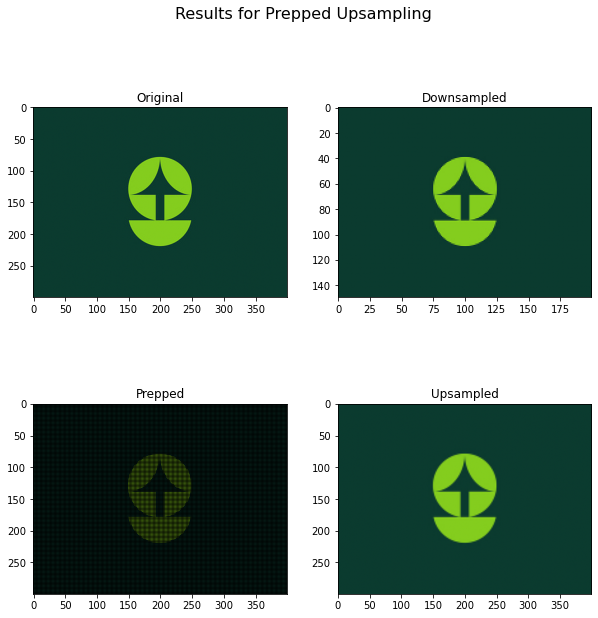

MSE 0.0010512757392989876
RMSE 0.03242338260112581
MAE 0.007079260620915033
PSNR 77.91363718721945
SSIM 0.999994081643056


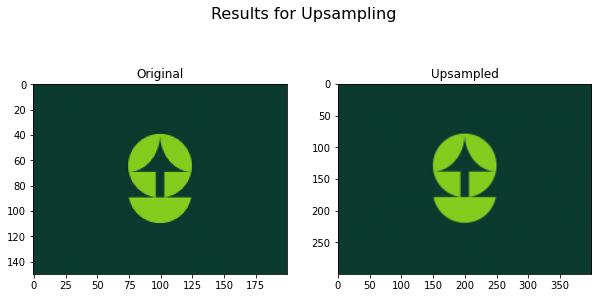

MSE 0.0010512757392989876
RMSE 0.03242338260112581
MAE 0.007079260620915033
PSNR 77.91363718721945
SSIM 0.999994081643056

AS YOU CAN SEE, BOTH PREPPED AND NO-PREP IMPLEMENTATIONS PRODUCE IDENTICAL RESULTS.
IT IS ONLY THE ADDED CONTROL WITH THE PREPPED VERSION THAT MAY MAKE ITS USE
BENEFICIAL FOR MORE COMPLEX UPSCALING SITUATIONS.


In [154]:
"""
Test upsampling for prepped approach.
"""
im = get_im("no_black_logo.jpg").astype(float) / 255
im = make_even_shape(im)

smaller_im = cv2_downsample(im)
prepped_im = prep_upsample(smaller_im)

upsampled_im = KNN_upsample_prepped(prepped_im, k=1)

display_prepped_upsampling_results(im, smaller_im, prepped_im, upsampled_im)

print("MSE", mse(im, upsampled_im))
print("RMSE", rmse(im, upsampled_im))
print("MAE", mae(im, upsampled_im))
print("PSNR", psnr(im, upsampled_im))
print("SSIM", ssim(im, upsampled_im))

"""
Test upsampling for no-prep approach.
"""
im = get_im("no_black_logo.jpg").astype(float) / 255
im = make_even_shape(im)

smaller_im = cv2_downsample(im)

upsampled_im = KNN_upsample_no_prep(smaller_im, k=1)

display_upsampling_results(smaller_im, upsampled_im)

print("MSE", mse(im, upsampled_im))
print("RMSE", rmse(im, upsampled_im))
print("MAE", mae(im, upsampled_im))
print("PSNR", psnr(im, upsampled_im))
print("SSIM", ssim(im, upsampled_im))

# Can delete this later
print("\nAS YOU CAN SEE, BOTH PREPPED AND NO-PREP IMPLEMENTATIONS PRODUCE IDENTICAL RESULTS.\nIT IS ONLY THE ADDED CONTROL WITH THE PREPPED VERSION THAT MAY MAKE ITS USE\nBENEFICIAL FOR MORE COMPLEX UPSCALING SITUATIONS.")

Original shape (300, 400, 3)
Result (upsampled) shape (900, 1200, 3)


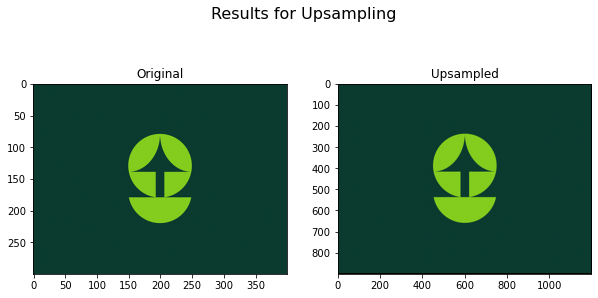

In [155]:
"""
Test upsampling for no-prep approach with variable factor.
"""
im = get_im("no_black_logo.jpg").astype(float) / 255
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factor(im, k=1, factor=3)
print("Result (upsampled) shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im)

# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# Perhaps we can use library functions to reshape/resize the orignal image to our target and then compute metrics

Original shape (300, 400, 3)
Result shape (600, 1600, 3)


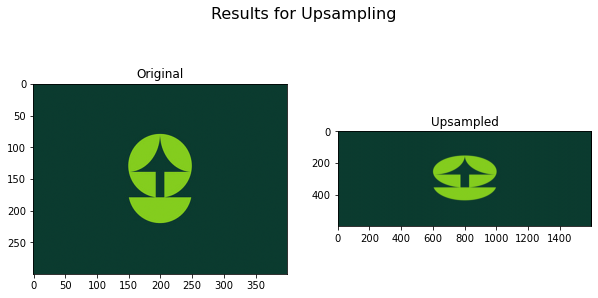

Original shape (300, 400, 3)
Result shape (1200, 800, 3)


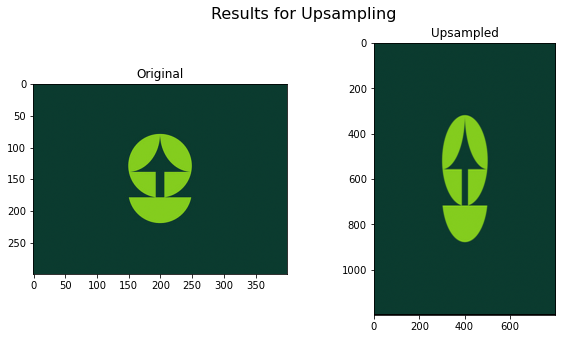

In [156]:
"""
Test upsampling for no-prep approach with variable and dissimilar factors in both dimensions.
"""
im = get_im("no_black_logo.jpg").astype(float) / 255
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=2, factor2=4)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im)



im = get_im("no_black_logo.jpg").astype(float) / 255
im = make_even_shape(im)
print("Original shape", im.shape)

upsampled_im = KNN_upsample_variable_factors(im, k=2, factor1=4, factor2=2)
print("Result shape", upsampled_im.shape)

display_upsampling_results(im, upsampled_im)


# Cannot compute metrics when upsampling to a shape dissimilar from the original image
# We can compute matrics with respect to the aspect ratio being converted